<div class="alert alert-block alert-success">
This jupyter notebook is part of the supplementary material for the book "Materials Data Science" (Stefan Sandfeld, Springer, 2024, DOI 10.1007/978-3-031-46565-9). For further details please refer to the accompanying webpage at <a href="https://mds-book.org">https://mds-book.org</a>.
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt


## 12.5 A Worked Example of Simple Linear Regression

(More information and step by step explanations are given in section 12.5 of the MDS book).

### 12.5.1 Python Implementation
We start by initialization of the random number generator and creating the training dataset where the feature X is superimposed with random noise. The target values Y are a linear function of the feature X and additionally also superimposed with random noise.

In [2]:
rng = np.random.default_rng()

xlim = np.array((-2., 3.5))   # min. and max. x-values
n_total_data = 50   # number of data points

slope, offset = 0.5, -0.7

X_train = xlim[0] + rng.random(size=n_total_data) * (xlim[1] - xlim[0])
eps_noise = 0.5 * rng.standard_normal(n_total_data)
y_train = offset + slope * X_train + eps_noise

Show the data and the true function:

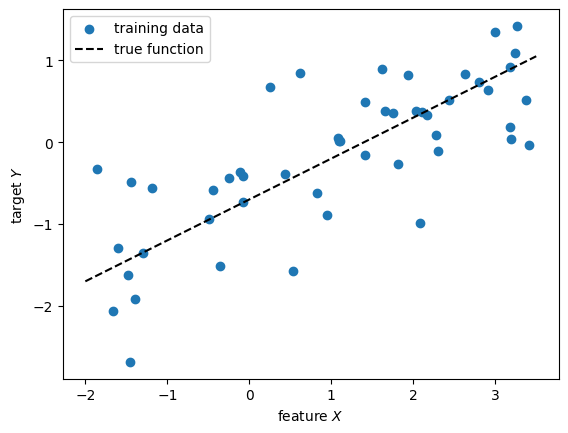

In [3]:
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, label='training data')
ax.plot(xlim, offset + slope * xlim, ls='--', c='k', label='true function')
ax.set(xlabel="feature $X$", ylabel="target $Y$")
ax.legend();

As a next step, we can now define a function that returns the two components of the gradient of the cost
function, Eq. (12.32) and Eq. (12.33):

In [4]:
def gradient_of_cost(weights, X, y):
    y_pred = weights[0] + weights[1] * X
    N = y_pred.size
    residual = y - y_pred
    dL_dw0 = -(2 / N) * np.sum(residual)
    dL_dw1 = -(2 / N) * np.sum(residual * X)
    
    return np.array([dL_dw0, dL_dw1])

Similarly, we also implement a function for computing the MSE cost:

In [5]:
def cost(weights, X, y):
    y_pred = weights[0] + weights[1] * X
    N = y_pred.size
    mse = (1 / N) * np.sum((y - y_pred) ** 2)
    return mse

Define a few numerical parameter and the initial guess for the values of the two weights:

In [6]:
maximum_number_of_steps = 100
step_size = 0.05
tolerance = 1e-3
initial_weights = np.array([2.2, 1.5])

We can now perform the update scheme where a maximum of `maximum_number_of_steps` update steps are allowed in the for loop (observe that the `else` clause has the same level of indentation as the `for` statement -- it is **not** an IF-ELSE but a FOR-ELSE!!). 

In [7]:
weights = initial_weights.copy()
for nstep in range(maximum_number_of_steps):
    delta_w = step_size * (-gradient_of_cost(weights, X_train, y_train))
    weights += delta_w  

    if np.linalg.norm(delta_w) < tolerance:
        print(f"converged after {nstep} steps")
        break
else:
    print("ERROR: maximum number of iterations exceeded")

converged after 76 steps


<div class="alert alert-block alert-danger">
<b>Mind the trickiness of "=":</b><br>
In the first line we had to copy the initial weights. Without this, <tt>weights</tt> is a reference, i.e., it is just another name for the same chunk of memory; without copying <tt>initial_weights</tt> would get updated in the for loop and would have the same value as <tt>weights</tt> in the end. The same also holds for the elements of <tt>all_cost_values</tt>.
</div>


We summarize a few results:

In [8]:
print(f'w0 = {weights[0]:.3f}, w1 = {weights[1]:.3f}')
print(f'{nstep + 1} steps taken')
print(f'final cost J: {cost(weights, X_train, y_train):.4f}')

w0 = -0.606, w1 = 0.424
77 steps taken
final cost J: 0.3493


Note that these results are slightly different than those recorded in chapter 12 of the book. The reason is that the training dataset was randomly sampled.

### 12.5.2 Visualization and Discussion of Training Results
In the following we visualize how the regression line and the cost changes as the weights are being updated in the steepest descent method:

In [9]:
weights = initial_weights.copy()

# initialize the lists that keep track of the changes
all_weight_values = [initial_weights.copy()]
all_cost_values = []

for n_iter in range(maximum_number_of_steps):
    delta_w = step_size * (-gradient_of_cost(weights, X_train, y_train))
    weights += delta_w  

    # store changes
    all_weight_values.append(weights.copy())
    all_cost_values.append(cost(weights, X_train, y_train))

    if np.linalg.norm(delta_w) < tolerance:
        print(f"converged after {n_iter} steps")
        break
else:
    print("ERROR: maximum number of iterations exceeded")


all_weight_values = np.array(all_weight_values)
all_cost_values = np.array(all_cost_values)


converged after 76 steps


Show how the line's position and inclination changes during the cost minimization:

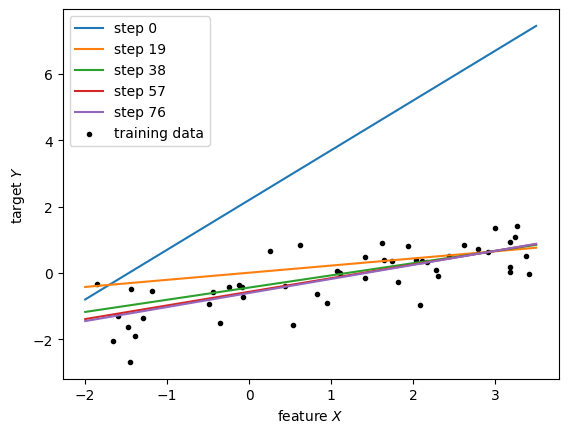

In [10]:
fig, ax = plt.subplots()

# 5 equidistant plot steps ('//' is an integer division)
# n_iter is the variable from the for loop above
plot_steps = [n * n_iter // 4 for n in range(5)]
for n in plot_steps:
    w0, w1 = all_weight_values[n]
    ax.plot(xlim, w0 + w1 * xlim, ls='-', label=f'step {n}')

ax.scatter(X_train, y_train, marker='.', c='k', label='training data')
ax.set(xlabel="feature $X$", ylabel="target $Y$")
ax.legend();

Next, we create a heatmap plot that visualizes the cost values as a function of the two weights. Additionally, plot the trajectory of the weight values during the steepest descent iterations. The first step is to prepare the 2D data. 

Creating a 2D heatmap along with contour lines in Matplotlib requires careful alignment of the grid points used by the heatmap and the contour plot. E.g., the imshow function places the origin at the top left by default and centers pixels at integer coordinates, while contour assumes that the grid points are located at the corners of the cells. To align them correctly, we need to ensure that both are using the same coordinate system.

We'll use pcolormesh for the heatmap because it allows us to specify the edges of the grid cells (the coordinates of the corners of quadrilaterals of a pcolormesh) explicitly. Specifying `shading='flat'` indicates that the color of the quadrilateral is given from the value at the center of the cell. The `contour` plot inherently assumes the data points are at the grid corners.

In [11]:

# define the range of the points in the weight space
w0_range = (-1.25, 2.5)
w1_range = (-0.65, 2.5)

# compute the edge coordinates of the quadrilaterals of the grid
xe = np.linspace(*w0_range, 100)
ye = np.linspace(*w1_range, 100)

# compute the center points of the grid rectangles for evaluating the cost function
dx = xe[1] - xe[0]  # width of a 
dy = ye[1] - ye[0]
xc = xe[:-1] + dx / 2
yc = ye[:-1] + dy / 2

# evaluate cost function at cell centers
X, Y = np.meshgrid(xc, yc)
Z = np.empty_like(X)
for col, w0 in enumerate(xc):
    for row, w1 in enumerate(yc):
        Z[row, col] = cost(np.array([w0, w1]), X_train, y_train)

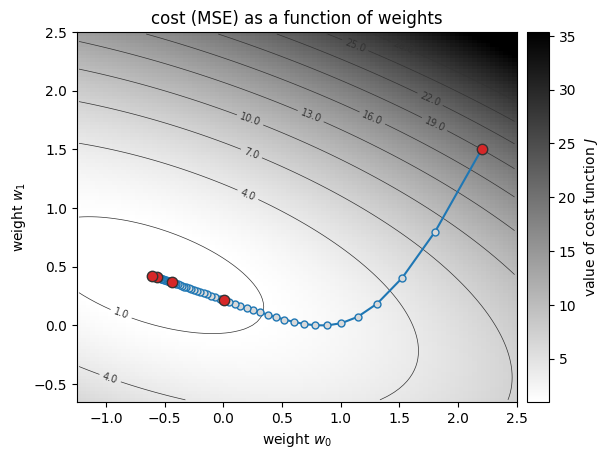

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()

# plot the 2D heatmap with contour lines
im = ax.pcolormesh(xe, ye, Z, cmap='gray_r', vmin=1, vmax=0.9*Z.max(), shading='flat')
cs = ax.contour(X, Y, Z, np.arange(1, 30, 3), colors='0.2', linewidths=0.5)
ax.clabel(cs, cs.levels, inline=True, fmt=lambda x: f"{x:.1f}", fontsize='x-small')
ax.set(aspect='equal', xlabel='weight $w_0$', ylabel='weight $w_1$', title='cost (MSE) as a function of weights')

# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
cax.set(ylabel='value of cost function $J$')

# plot the trajectory during weights optimization
ax.plot(all_weight_values[:, 0], all_weight_values[:, 1], '-',  c='C0')
ax.plot(all_weight_values[:, 0], all_weight_values[:, 1], '.', ms=10, c='C0', mfc='0.85')

# highlight the weights for which we showed the regression lines above:
for n in plot_steps:
    ax.plot(all_weight_values[n, 0], all_weight_values[n, 1], '.', ms=15, c='0.2', mfc='C3')